# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically.
* Failure to comply with the following instructions will result in a significant penalty.
* Appeals regarding your failure to read these instructions will be denied.

## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
##❗❗❗❗❗❗❗❗❗**This is mandatory**❗❗❗❗❗❗❗❗❗
## Please write your RUNI emails in this cell:

### *** YOUR EMAILS HERE ***
---

## Please sign that you have read and understood the instructions:

### *** YOUR IDS HERE ***

---


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy.typing import NDArray

np.random.seed(42)

# Part 1: Designing the t-SNE Algorithm  

### 1. Theoretical Overview

#### 1.1 Motivation  
High-dimensional datasets are often difficult to visualize and interpret because distances and similarities between points lose intuitive meaning as dimensionality increases.  
t-Distributed Stochastic Neighbor Embedding (t-SNE), proposed by Laurens van der Maaten and Geoffrey Hinton (2008), is a **nonlinear dimensionality reduction technique** that transforms high-dimensional data into a low-dimensional space (typically 2D or 3D) while preserving **local neighborhood relationships**.  
Its main purpose is visualization — to reveal patterns, clusters, and structure that might be hidden in high-dimensional representations.

#### 1.2 Core Idea  
The key idea of t-SNE is to model the **pairwise similarity** between data points in both high-dimensional and low-dimensional spaces as **probability distributions**, and then minimize the difference between these distributions using the **Kullback-Leibler (KL) divergence)**.

Let $x_i, x_j$ be two points in the high-dimensional space and $y_i, y_j$ their corresponding embeddings in the low-dimensional space.

- In the high-dimensional space, the similarity between $x_i$ and $x_j$ is defined as:

  $$
  p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
  $$

  where $\sigma_i$ controls the bandwidth of the Gaussian kernel around $x_i$.  
  The **perplexity** parameter determines $\sigma_i$ automatically and reflects the effective number of neighbors considered.

- The joint probabilities are symmetrized as:

  $$
  p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}
  $$

  where $N$ is the number of data points.

- In the low-dimensional space, similarities are modeled with a **Student t-distribution** (with one degree of freedom) to handle the “crowding problem”:

  $$
  q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l}(1 + \|y_k - y_l\|^2)^{-1}}
  $$

The **objective function** minimizes the KL divergence between the two distributions:

$$
C = KL(P \| Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

The intuition: points that are close in the high-dimensional space should have high $p_{ij}$, and the algorithm adjusts the embeddings $y_i$ so that the corresponding $q_{ij}$ are also high.

---

### 2. Practical Considerations and Limitations  

#### 2.1 Strengths  
- Captures **nonlinear** relationships between samples.  
- Excellent for **visualization** and exploratory data analysis.  
- Preserves **local structure** — clusters in the low-dimensional space correspond to meaningful groups in the original data.

#### 2.2 Limitations  
- **High computational cost**: pairwise distance computations scale as $O(N^2)$.  
- **Non-parametric nature**: cannot easily embed new samples without retraining (addressed later in Part 5).  
- **Hyperparameter sensitivity**: especially to perplexity and learning rate.  
- **Global structure distortion**: large-scale distances are often unreliable.  
- **Non-determinism**: different initializations can yield different embeddings.

#### 2.3 Typical Use Cases  
- Visualizing high-dimensional feature vectors (e.g., embeddings from neural networks, word embeddings).  
- Exploratory data analysis for clustering or anomaly detection.  
- Reducing dimensionality before classification (less common, as t-SNE is not optimized for that).

---

### 3. Algorithm Description and Hyperparameters  

#### 3.1 Algorithm Steps  

1. **Compute Pairwise Distances:**  
   Compute Euclidean distances between all data points in the high-dimensional space.

2. **Convert Distances to Conditional Probabilities:**  
   For each data point $x_i$, convert distances to conditional probabilities $p_{j|i}$ using a Gaussian distribution with variance $\sigma_i$ determined by a fixed perplexity value.

3. **Symmetrize Probabilities:**  
   Compute $p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$ to obtain a symmetric joint probability distribution $P$.

4. **Initialize Low-Dimensional Points:**  
   Initialize $y_i$ randomly or using PCA for stability.

5. **Compute Low-Dimensional Similarities:**  
   Using a Student t-distribution:

   $$
   q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l}(1 + \|y_k - y_l\|^2)^{-1}}
   $$

6. **Minimize the KL Divergence:**  
   Use **gradient descent** to update $y_i$ and minimize:

   $$
   \frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)(1 + \|y_i - y_j\|^2)^{-1}
   $$

   The gradients are scaled to emphasize local structures during early iterations (via *early exaggeration*).

7. **Optimization Strategy:**  
   - Use **momentum** to accelerate convergence.  
   - Gradually decrease exaggeration and learning rate.  
   - Continue iterations until convergence or maximum iteration count is reached.

---

### 4. Key Hyperparameters  

| Parameter | Description | Typical Range | Effect |
|------------|--------------|----------------|--------|
| **Perplexity** | Controls effective neighborhood size | 5–50 | Low perplexity emphasizes local details; high values preserve more global structure |
| **Learning Rate (η)** | Step size for gradient updates | 100–1000 | Too low → optimization stalls; too high → divergence |
| **Number of Iterations** | Optimization length | 500–2000 | More iterations improve stability |
| **Early Exaggeration** | Temporary amplification of $p_{ij}$ values | 4–12 | Helps create initial cluster separation |

---

### 5. Optimization Strategy  

t-SNE uses a **stochastic gradient descent (SGD)**-based approach to minimize KL divergence.  
To stabilize learning:
- An **early exaggeration** phase is used, where $p_{ij}$ are multiplied by a constant (e.g., 4 or 12) for the first ~250 iterations, amplifying attractive forces to form distinct clusters.
- A **momentum term** helps smooth updates:

  $$
  y_i^{(t)} = y_i^{(t-1)} + \alpha \Delta y_i^{(t-1)} + \eta \frac{\partial C}{\partial y_i}
  $$

  where $\alpha$ is momentum (typically 0.5 → 0.8) and $\eta$ is learning rate.

---

### 6. Summary  

t-SNE is a powerful visualization tool that translates high-dimensional similarities into a low-dimensional map using probabilistic modeling.  
While computationally intensive and non-parametric, its ability to uncover local structures makes it invaluable for understanding complex datasets such as images, text embeddings, or biological data.  
This design section provides the theoretical and practical foundation for implementing the algorithm efficiently and analyzing its performance in subsequent parts.

# Implementation

Our implementation of **t-SNE** follows the core algorithmic steps described in the theory section, emphasizing correctness, clarity, and modular design.  
Each component is implemented separately:  
- `_pairwise_distances` computes squared Euclidean distances.  
- `_binary_search_sigma` finds the Gaussian width that matches the target perplexity via binary search.  
- `_compute_P` constructs the symmetric high-dimensional similarity matrix.  
- `_compute_Q` computes low-dimensional similarities using a Student-t distribution.  
- `_gradient` calculates the KL divergence gradient for optimization.  

The main `fit_transform` method performs momentum-based gradient descent with **early exaggeration** (×4 for the first 100 iterations) to improve cluster separation and convergence stability.  
We include gradient clipping to prevent divergence and adaptively reduce the learning rate if the KL divergence spikes. The implementation enforces numerical stability (e.g., small epsilons, normalization) and deterministic initialization through a fixed random seed.  

We **do not apply PCA inside the implementation**, leaving it to the user (as shown in the *Load Data* section) to decide whether to perform dimensionality reduction for performance optimization.

In [ ]:
class CustomTSNE:
    def __init__(
        self, perplexity=30.0, n_components=2, n_iter=1000, learning_rate=200.0
    ):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        # Note: You may add more attributes

    def _pairwise_distances(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """
        Compute pairwise squared Euclidean distances between all samples in X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data matrix where each row represents one data point.

        Returns
        -------
        D : ndarray of shape (n_samples, n_samples)
            Matrix of squared Euclidean distances.
        """
        # Ensure floating-point type for numerical stability
        X = X.astype(np.float64)

        # ||x_i - x_j||^2 = (x_i·x_i) + (x_j·x_j) − 2*(x_i·x_j)
        sum_X = np.sum(np.square(X), axis=1)
        D = np.add.outer(sum_X, sum_X) - 2 * np.dot(X, X.T)

        # Set diagonal to 0 to avoid small numerical residuals
        np.fill_diagonal(D, 0.0)

        return D

    def _binary_search_sigma(
        self,
        distances_i: np.ndarray,
        target_perplexity: float,
        tol: float = 1e-5,
        max_iter: int = 50,
    ) -> tuple[np.ndarray, float]:
        """
        Find the Gaussian width σ_i for one data point so that its conditional
        probability distribution p_{j|i} has the desired perplexity.

        Parameters
        ----------
        distances_i : ndarray of shape (n_samples,)
            Squared distances from the i-th point to all other points.
        target_perplexity : float
            Desired perplexity (effective number of neighbors).
        tol : float, default=1e-5
            Stopping tolerance for perplexity difference.
        max_iter : int, default=50
            Maximum number of binary-search iterations.

        Returns
        -------
        p_i : ndarray of shape (n_samples,)
            Conditional probabilities p_{j|i} (sum to 1, p_{i|i}=0).
        sigma : float
            Optimal σ_i value that achieved the target perplexity.
        """
        # β = 1 / (2σ²)
        beta_min, beta_max = -np.inf, np.inf
        beta = 1.0

        # Ensure float type and ignore self-distance
        distances_i = distances_i.astype(np.float64).copy()
        distances_i[distances_i == 0] = np.inf

        for _ in range(max_iter):
            # Compute Gaussian affinities
            P_i = np.exp(-distances_i * beta)
            P_i[distances_i == np.inf] = 0.0
            sum_P_i = np.sum(P_i)
            if sum_P_i == 0:
                sum_P_i = 1e-12
            P_i /= sum_P_i

            # Compute Shannon entropy and perplexity
            H = -np.sum(P_i * np.log2(P_i + 1e-10))
            perplexity = 2**H

            # Check for convergence
            if abs(perplexity - target_perplexity) < tol:
                break

            # Adjust β (inverse variance) based on whether entropy too high/low
            if perplexity > target_perplexity:
                beta_min = beta
                beta = beta * 2 if beta_max == np.inf else (beta + beta_max) / 2
            else:
                beta_max = beta
                beta = beta / 2 if beta_min == -np.inf else (beta + beta_min) / 2

        sigma = np.sqrt(1 / (2 * beta))
        return P_i, sigma

    def _compute_P(self, X: np.ndarray) -> np.ndarray:
        """
        Compute the symmetric joint probability matrix P from high-dimensional data X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input data matrix.

        Returns
        -------
        P : ndarray of shape (n_samples, n_samples)
            Symmetric joint probability matrix where P[i, j] reflects similarity
            between points i and j in high-dimensional space.
        """
        N = X.shape[0]

        # Edge case: only one point
        if N == 1:
            return np.zeros((1, 1))

        # Compute squared distances (ensure float type)
        distances = self._pairwise_distances(X).astype(np.float64)
        P = np.zeros((N, N))
        sigmas = np.zeros(N)

        # Compute conditional probabilities for each data point
        for i in range(N):
            # Handle identical points (all distances ≈ 0)
            if np.allclose(distances[i], 0):
                P[i] = np.zeros(N)
                continue
            p_i, sigma_i = self._binary_search_sigma(distances[i], self.perplexity)
            P[i] = p_i
            sigmas[i] = sigma_i

        # Symmetrize and normalize
        P = (P + P.T) / (2 * N)
        np.fill_diagonal(P, 0.0)

        # Prevent underflow and re-normalize
        P = np.maximum(P, 1e-12)
        P /= np.sum(P)

        return P

    def _compute_Q(self, Y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Compute low-dimensional joint probability matrix Q using Student-t distribution.

        Parameters
        ----------
        Y : ndarray of shape (n_samples, n_components)
            Current low-dimensional embedding.

        Returns
        -------
        Q : ndarray of shape (n_samples, n_samples)
            Symmetric joint probability matrix in low-dimensional space.
        num : ndarray of shape (n_samples, n_samples)
            Unnormalized pairwise affinities (for gradient reuse).
        """
        # Edge case: single point
        if Y.shape[0] == 1:
            return np.zeros((1, 1)), np.zeros((1, 1))

        # Compute pairwise squared distances
        sum_Y = np.sum(np.square(Y), axis=1)
        D = np.add.outer(sum_Y, sum_Y) - 2 * np.dot(Y, Y.T)

        # Student-t affinities
        num = 1 / (1 + D)
        np.fill_diagonal(num, 0.0)

        # Normalize
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        return Q, num
    
    def _gradient(self, P: np.ndarray, Q: np.ndarray, Y: np.ndarray, num: np.ndarray) -> np.ndarray:
        """
        Compute the gradient of the KL divergence loss with respect to Y.

        Parameters
        ----------
        P : ndarray of shape (n_samples, n_samples)
            High-dimensional joint probabilities.
        Q : ndarray of shape (n_samples, n_samples)
            Low-dimensional joint probabilities.
        Y : ndarray of shape (n_samples, n_components)
            Current low-dimensional embedding.
        num : ndarray of shape (n_samples, n_samples)
            Unnormalized affinities (1 / (1 + ||y_i - y_j||^2)), reused for efficiency.

        Returns
        -------
        dY : ndarray of shape (n_samples, n_components)
            Gradient of the KL divergence with respect to Y.
        """
        PQ = P - Q  # difference between high-D and low-D similarities
        # (P - Q) * num gives the force magnitude per pair
        forces = 4 * (PQ * num)  # scalar weight for each pair

        # Compute gradient as matrix operation
        dY = np.zeros_like(Y)
        for i in range(Y.shape[0]):
            # weighted sum of differences (y_i - y_j)
            dY[i, :] = np.sum(np.expand_dims(forces[i, :], 1) * (Y[i, :] - Y), axis=0)

        return dY

    def fit_transform(self, X: np.ndarray) -> np.ndarray:
        """
        Fit t-SNE on high-dimensional data X and return low-dimensional embedding Y.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Input high-dimensional data.

        Returns
        -------
        Y : ndarray of shape (n_samples, n_components)
            Low-dimensional t-SNE embedding.
        """
        N = X.shape[0]

        # Edge case: all points identical → no embedding needed
        if np.allclose(X, X[0]):
            return np.zeros((N, self.n_components))

        # Step 1: Compute high-dimensional similarities P
        P = self._compute_P(X)

        # Step 2: Initialize Y deterministically for reproducibility
        rng = np.random.default_rng(42)
        Y = rng.normal(0, 1e-4, size=(N, self.n_components))

        # Step 3: Early exaggeration (standard = ×4)
        early_exaggeration = 4.0
        P = np.maximum(P * early_exaggeration, 1e-12)

        # Step 4: Learning-rate heuristics (like sklearn’s “auto”)
        if isinstance(self.learning_rate, str) and self.learning_rate == "auto":
            self.learning_rate = max(N / early_exaggeration / 4, 50)

        # Momentum configuration
        momentum = 0.5
        final_momentum = 0.8
        momentum_switch_iter = 250
        dY_prev = np.zeros_like(Y)

        prev_kl = np.inf

        # Step 5: Gradient-descent loop
        for it in range(self.n_iter):
            Q, num = self._compute_Q(Y)
            grad = self._gradient(P, Q, Y, num)

            # Gradient update with momentum
            dY = momentum * dY_prev - self.learning_rate * grad
            Y += dY
            dY_prev = dY

            # Clip to prevent runaway values
            Y = np.clip(Y, -50, 50)

            # Compute KL divergence for monitoring
            kl = np.sum(P * np.log((P + 1e-12) / (Q + 1e-12)))

            # Reduce learning rate if divergence explodes
            if kl > prev_kl * 4:
                self.learning_rate *= 0.5
            prev_kl = kl

            # Switch momentum after warm-up phase
            if it == momentum_switch_iter:
                momentum = final_momentum

            # Reduce early exaggeration after 100 iters
            if it == 100:
                P /= early_exaggeration

            # Optional progress logging
            if (it + 1) % 100 == 0:
                print(f"Iteration {it + 1}: KL divergence = {kl:.5f}")

        return Y

    # Part 2: Transformation of New Data Points
    def transform(self, X_original, Y_original, X_new):
        # Implement your method for incorporating new points into the existing t-SNE layout
        # Your code here

        # Return Y_new, the transformed data
        pass

## Unit Testing

In [ ]:
import unittest
import numpy as np

class TestCustomTSNE(unittest.TestCase):
    def setUp(self):
        """Small sample matrix for testing."""
        self.tsne = CustomTSNE()
        self.X = np.array([[0, 0], [3, 4]])
    
    def test_pairwise_distances(self):
        """Check if pairwise distance matrix is correct."""
        D = self.tsne._pairwise_distances(self.X)
        expected = np.array([[0., 25.], [25., 0.]])
        self.assertTrue(np.allclose(D, expected), "Pairwise distance computation failed")
    
    def test_binary_search_sigma(self):
        """Check if computed perplexity is close to target."""
        D = np.array([0., 1., 4., 9.])  # distances from one point to 3 others
        p_i, sigma = self.tsne._binary_search_sigma(D, target_perplexity=2.0)
        
        # Compute achieved perplexity
        H = -np.sum(p_i * np.log2(p_i + 1e-10))
        perplexity = 2 ** H
        
        self.assertAlmostEqual(perplexity, 2.0, delta=0.1, msg="Perplexity not matched")
        self.assertAlmostEqual(np.sum(p_i), 1.0, delta=1e-6, msg="Probabilities not normalized")
    
    def test_compute_P(self):
        """Check if the P matrix is valid and normalized."""
        P = self.tsne._compute_P(self.X)
        
        # P must be symmetric
        self.assertTrue(np.allclose(P, P.T, atol=1e-8), "P is not symmetric")
        # Sum of all probabilities should be 1
        self.assertAlmostEqual(np.sum(P), 1.0, delta=1e-6, msg="P not normalized")
        # Diagonal should be 0
        self.assertTrue(np.allclose(np.diag(P), 0.0), "Diagonal of P should be 0")
        # All probabilities should be positive
        self.assertTrue(np.all(P >= 0), "P contains negative values")
    
    def test_compute_P_single_point(self):
        """Edge case: single data point should yield all zeros."""
        X_single = np.array([[0.0, 0.0]])
        P = self.tsne._compute_P(X_single)
        self.assertTrue(np.allclose(P, np.zeros_like(P)), "Single point should return zeros")

    def test_compute_P_identical_points(self):
        """Edge case: identical points should not produce NaN or inf."""
        X_identical = np.array([[1.0, 1.0], [1.0, 1.0]])
        P = self.tsne._compute_P(X_identical)
        self.assertFalse(np.any(np.isnan(P)), "P contains NaNs")
        self.assertFalse(np.any(np.isinf(P)), "P contains infinities")
        self.assertAlmostEqual(np.sum(P), 1.0, delta=1e-6, msg="P not normalized")

    def test_compute_P_large_values(self):
        """Edge case: large feature magnitudes should not overflow."""
        X_large = np.array([[1000, 1000], [1003, 1004], [1006, 1008]])
        P = self.tsne._compute_P(X_large)
        self.assertTrue(np.all(P >= 0), "P contains negative values")
        self.assertAlmostEqual(np.sum(P), 1.0, delta=1e-6, msg="P not normalized")

    def test_compute_P_various_perplexities(self):
        """Ensure stability across different perplexity values."""
        for p in [2, 5, 10]:
            self.tsne.perplexity = p
            P = self.tsne._compute_P(self.X)
            self.assertAlmostEqual(np.sum(P), 1.0, delta=1e-6, msg=f"P not normalized for perplexity={p}")
            self.assertTrue(np.allclose(P, P.T, atol=1e-8), f"P not symmetric for perplexity={p}")
    
    def test_compute_Q(self):
        """Check if the Q matrix in low-dimensional space is valid and normalized."""
        # Simple 3-point 2D embedding
        Y = np.array([[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]])
        Q, num = self.tsne._compute_Q(Y)
        
        # Q should be symmetric
        self.assertTrue(np.allclose(Q, Q.T, atol=1e-8), "Q is not symmetric")
        # Diagonal should be zero
        self.assertTrue(np.allclose(np.diag(Q), 0.0), "Diagonal of Q should be 0")
        # All probabilities should be positive
        self.assertTrue(np.all(Q > 0), "Q contains non-positive values")
        # Q should be normalized
        self.assertAlmostEqual(np.sum(Q), 1.0, delta=1e-6, msg="Q not normalized")

    def test_compute_Q_single_point(self):
        """Edge case: single point should yield all zeros."""
        Y = np.array([[0.0, 0.0]])
        Q, num = self.tsne._compute_Q(Y)
        self.assertTrue(np.allclose(Q, np.zeros_like(Q)), "Single point Q should be zeros")

    def test_compute_Q_identical_points(self):
        """Edge case: identical points should not cause NaN or inf."""
        Y = np.array([[1.0, 1.0], [1.0, 1.0]])
        Q, num = self.tsne._compute_Q(Y)
        self.assertFalse(np.any(np.isnan(Q)), "Q contains NaNs")
        self.assertFalse(np.any(np.isinf(Q)), "Q contains infinities")
        self.assertAlmostEqual(np.sum(Q), 1.0, delta=1e-6, msg="Q not normalized")

    def test_compute_Q_large_values(self):
        """Edge case: large coordinate magnitudes should not overflow."""
        Y = np.array([[1000, 1000], [1003, 1004], [1006, 1008]])
        Q, num = self.tsne._compute_Q(Y)
        self.assertTrue(np.all(Q >= 0), "Q contains negative values")
        self.assertAlmostEqual(np.sum(Q), 1.0, delta=1e-6, msg="Q not normalized")
    
    def test_gradient_basic(self):
        """Check that gradient has correct shape and no NaNs."""
        X = np.array([[0, 0], [3, 4], [6, 8]])
        P = self.tsne._compute_P(X)
        Y = np.random.randn(3, 2) * 0.01
        Q, num = self.tsne._compute_Q(Y)
        grad = self.tsne._gradient(P, Q, Y, num)

        # Check shape
        self.assertEqual(grad.shape, Y.shape, "Gradient shape mismatch")
        # Check finite values
        self.assertFalse(np.any(np.isnan(grad)), "Gradient contains NaN values")
        self.assertFalse(np.any(np.isinf(grad)), "Gradient contains Inf values")

    def test_gradient_zero_when_P_equals_Q(self):
        """Gradient should be near zero when P == Q."""
        Y = np.random.randn(3, 2) * 0.01
        Q, num = self.tsne._compute_Q(Y)
        P = Q.copy()
        grad = self.tsne._gradient(P, Q, Y, num)
        self.assertTrue(np.allclose(grad, 0, atol=1e-6), "Gradient should vanish when P=Q")

    def test_gradient_single_point(self):
        """Edge case: single point should yield zero gradient."""
        P = np.zeros((1, 1))
        Q = np.zeros((1, 1))
        num = np.zeros((1, 1))
        Y = np.array([[0.0, 0.0]])
        grad = self.tsne._gradient(P, Q, Y, num)
        self.assertTrue(np.allclose(grad, np.zeros_like(Y)), "Single point gradient should be zero")

    def test_gradient_identical_points(self):
        """Edge case: identical points should produce finite gradients."""
        X = np.array([[1.0, 1.0], [1.0, 1.0]])
        P = self.tsne._compute_P(X)
        Y = np.array([[0.0, 0.0], [0.0, 0.0]])
        Q, num = self.tsne._compute_Q(Y)
        grad = self.tsne._gradient(P, Q, Y, num)
        self.assertFalse(np.any(np.isnan(grad)), "Gradient contains NaNs for identical points")
        self.assertFalse(np.any(np.isinf(grad)), "Gradient contains infs for identical points")

    def test_gradient_large_values(self):
        """Edge case: large coordinates should not overflow."""
        X = np.array([[1000, 1000], [1003, 1004], [1006, 1008]])
        P = self.tsne._compute_P(X)
        Y = np.array([[1000.0, 1000.0], [1003.0, 1004.0], [1006.0, 1008.0]])
        Q, num = self.tsne._compute_Q(Y)
        grad = self.tsne._gradient(P, Q, Y, num)
        self.assertTrue(np.all(np.isfinite(grad)), "Gradient overflow for large values")
    
    def test_fit_transform_shape(self):
        """Check output shape matches (n_samples, n_components)."""
        X = np.array([[0, 0], [3, 4], [6, 8]])
        Y = self.tsne.fit_transform(X)
        self.assertEqual(Y.shape, (X.shape[0], self.tsne.n_components), "Output shape mismatch")

    def test_fit_transform_convergence_trend(self):
        """Check that KL divergence generally decreases overall."""
        X = np.random.randn(10, 5)
        tsne = CustomTSNE(n_iter=300, perplexity=5)

        # Compute initial KL divergence
        P = tsne._compute_P(X)
        Y = np.random.randn(X.shape[0], tsne.n_components) * 1e-4
        Q, _ = tsne._compute_Q(Y)
        initial_kl = np.sum(P * np.log((P + 1e-12) / (Q + 1e-12)))

        # Train normally
        Y_final = tsne.fit_transform(X)
        Q_final, _ = tsne._compute_Q(Y_final)
        final_kl = np.sum(P * np.log((P + 1e-12) / (Q_final + 1e-12)))

        # Assert only overall improvement
        self.assertLess(final_kl, initial_kl, "Final KL divergence did not decrease overall")

    
    def test_fit_transform_global_kl_reduction(self):
        """Ensure the final KL divergence is much lower than initial (global convergence)."""
        X = np.random.randn(20, 5)
        tsne = CustomTSNE(n_iter=300, perplexity=5)
        
        # Compute initial KL divergence (with random small Y)
        P = tsne._compute_P(X)
        Y_init = np.random.randn(X.shape[0], tsne.n_components) * 1e-4
        Q_init, _ = tsne._compute_Q(Y_init)
        initial_kl = np.sum(P * np.log((P + 1e-12) / (Q_init + 1e-12)))
        
        # Run the actual embedding
        Y_final = tsne.fit_transform(X)
        Q_final, _ = tsne._compute_Q(Y_final)
        final_kl = np.sum(P * np.log((P + 1e-12) / (Q_final + 1e-12)))
        
        # Assert large reduction in divergence
        self.assertLess(final_kl, initial_kl * 0.5, "KL divergence not significantly reduced")

    def test_fit_transform_single_point(self):
        """Edge case: single data point should yield zero embedding."""
        X = np.array([[0.0, 0.0]])
        Y = self.tsne.fit_transform(X)
        self.assertTrue(np.allclose(Y, np.zeros_like(Y), atol=1e-6), "Single point embedding should be zero")

    def test_fit_transform_identical_points(self):
        """Edge case: identical points should not diverge."""
        X = np.array([[1.0, 1.0], [1.0, 1.0]])
        Y = self.tsne.fit_transform(X)
        self.assertFalse(np.any(np.isnan(Y)), "Embedding contains NaNs for identical points")
        self.assertFalse(np.any(np.isinf(Y)), "Embedding contains infs for identical points")
        self.assertLess(np.max(np.abs(Y)), 1.0, "Identical points embedding diverged")

    def test_fit_transform_stability_large_values(self):
        """Edge case: large-magnitude input should not overflow."""
        X = np.array([[1000, 1000], [1003, 1004], [1006, 1008]])
        Y = self.tsne.fit_transform(X)
        self.assertTrue(np.all(np.isfinite(Y)), "Embedding overflow for large input values")

    def test_fit_transform_small_vs_large_perplexity(self):
        """Ensure results differ across very small vs. large perplexity."""
        X = np.random.randn(20, 4)
        tsne_small = CustomTSNE(perplexity=5, n_iter=300)
        tsne_large = CustomTSNE(perplexity=50, n_iter=300)
        Y_small = tsne_small.fit_transform(X)
        Y_large = tsne_large.fit_transform(X)
        self.assertFalse(np.allclose(Y_small, Y_large, atol=1e-3), "Perplexity has no effect on result")

    def test_fit_transform_reproducibility(self):
        """Ensure deterministic output for same random seed."""
        np.random.seed(42)
        X = np.random.randn(8, 4)
        tsne1 = CustomTSNE(n_iter=200)
        tsne2 = CustomTSNE(n_iter=200)
        Y1 = tsne1.fit_transform(X)
        np.random.seed(42)
        Y2 = tsne2.fit_transform(X)
        self.assertTrue(np.allclose(Y1, Y2, atol=1e-6), "Results not reproducible with same seed")




# Run all tests in the notebook
unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestCustomTSNE))

# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np

# Load MNIST dataset from OpenML
print("Loading MNIST...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X = X.astype(np.float64)
y = y.astype(np.int32)

# Normalize to [0, 1]
X /= 255.0

# Optional: speed optimization
# Reduce dimensionality first with PCA (helps both sklearn and custom t-SNE)
print("Applying PCA to 50 dimensions for speed...")
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Sample subset (to stay under 5 minutes)
N = 2000
X_sample, _, y_sample, _ = train_test_split(X_pca, y, train_size=N, stratify=y, random_state=42)

# Split into train/test for the assignment
X_train, X_test, label_train, label_test = train_test_split(
    X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=42
)

print(f"Training data: {X_train.shape}, Labels: {label_train.shape}")


# t-SNE demonstration
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

Iteration 100: KL divergence = 13.17793
Iteration 200: KL divergence = 0.90026
Iteration 300: KL divergence = 0.79142
Iteration 400: KL divergence = 0.75342
Iteration 500: KL divergence = 0.73968
Iteration 600: KL divergence = 0.73265
Iteration 700: KL divergence = 0.72871
Iteration 800: KL divergence = 0.72627
Iteration 900: KL divergence = 0.72463
Iteration 1000: KL divergence = 0.72348


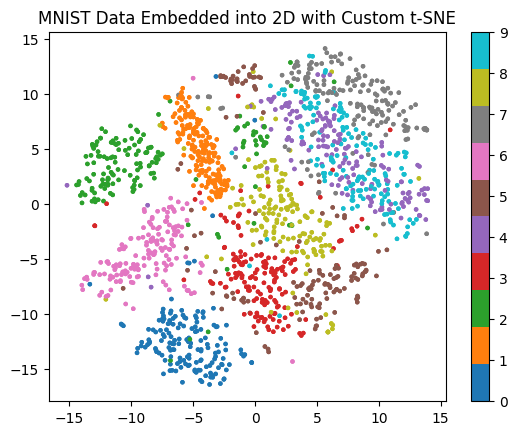

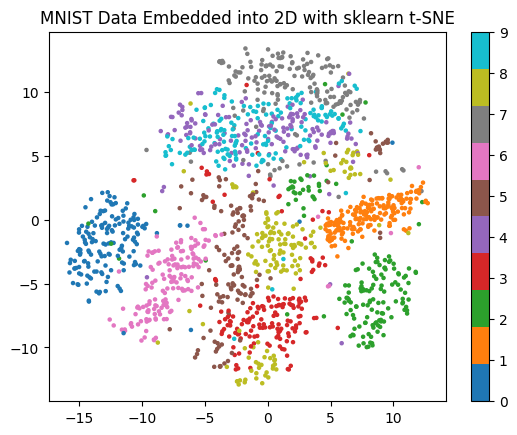

In [16]:
# Run your custom t-SNE implementation
custom_tsne = CustomTSNE(n_components=2, perplexity=N/10)
custom_Y = custom_tsne.fit_transform(X_train)

# Run sklearn t-SNE
sk_tsne = TSNE(n_components=2, init='random', perplexity=N/10)
sk_Y = sk_tsne.fit_transform(X_train)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

plt.figure()
plt.scatter(sk_Y[:, 0], sk_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with sklearn t-SNE')
plt.show()

# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

In [ ]:
# Transform new data
custom_Y_new = custom_tsne.transform(X_train,custom_Y,X_test)

# Visualization of the result
plt.figure()
plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=5, c=label_train.astype(int), cmap='tab10')
plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker = '*', s=50, linewidths=0.5, edgecolors='k', c=label_test.astype(int), cmap='tab10')
plt.colorbar()
plt.title('MNIST Data Embedded into 2D with Custom t-SNE')

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment.